In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brandonrtl","key":"b4040f42245189e1518e96a9cf56ac92"}'}

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
! mkdir simpsons
! unzip the-simpsons-characters-dataset.zip -d simpsons

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: simpsons/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg  
  inflating: simpso

In [ ]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=38fc8b67cfa98a6a333ec22714826cb9269c4a4587bcdd4560b06a9624249360
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
pip install torchview

In [31]:
from pathlib import Path
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plot
import numpy as np
from torchsummary import summary
from torchviz import make_dot
import graphviz
from torchview import draw_graph
import torch.optim as optim
import time
from torchvision import models
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [32]:
class SimpsonsDataset(Dataset):
    def __init__(self, path_list, transform=None):
        super().__init__()

        self.path_list = path_list
        self.transform = transform

        self.labels = [file.parent.name for file in self.path_list]
        self.length = len(path_list)
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.length

    def get_label_encoder(self):
      return self.label_encoder

    def __getitem__(self, index):
        img_path = str(self.path_list[index])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        label_str = str(self.path_list[index].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        return image, label

In [33]:
train_dir = Path('/content/simpsons/simpsons_dataset/')
image_files = list(train_dir.rglob("*.jpg"))

In [34]:
image_files[0]

PosixPath('/content/simpsons/simpsons_dataset/groundskeeper_willie/pic_0000.jpg')

In [35]:
labels = [path.parent.name for path in image_files]

In [36]:
labels[0]

'groundskeeper_willie'

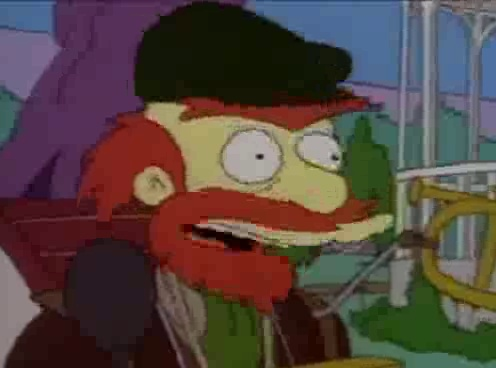

In [37]:
Image.open(image_files[0])

In [38]:
train_images, test_imesa = train_test_split(
    image_files, test_size=0.25, stratify=labels
)

In [39]:
batch_size = 64

norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tranform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params)

     ])

test_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((128, 128)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(*norm_params)])


In [40]:
train_dataset = SimpsonsDataset(train_images, train_tranform)
test_dataset = SimpsonsDataset(test_imesa, test_transform)

Number of train samples: 31399
Number of test samples: 10467


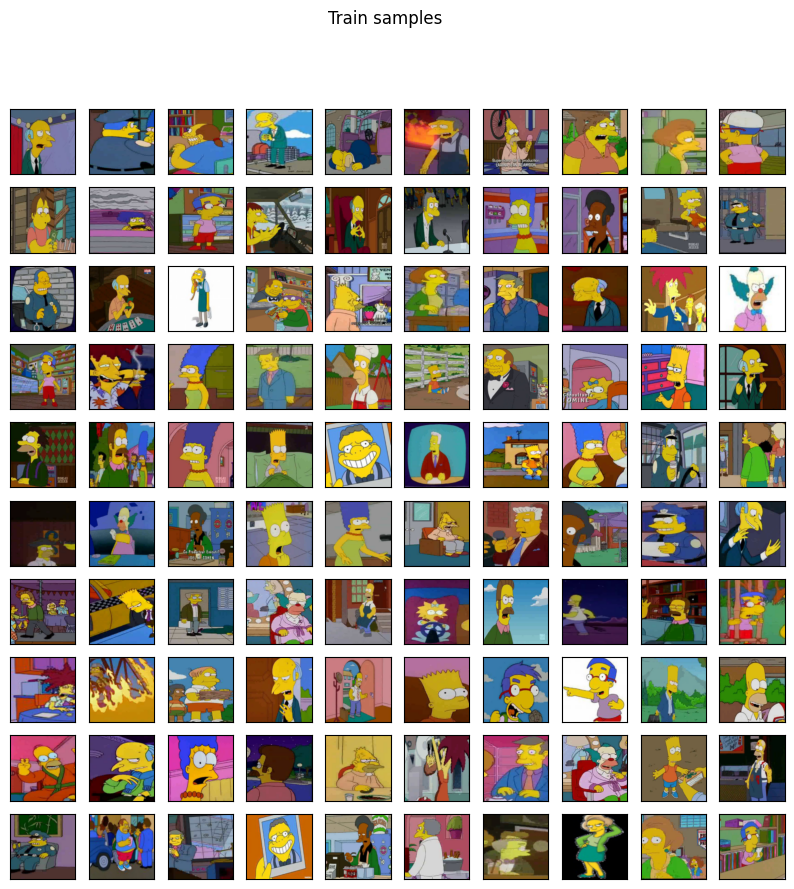

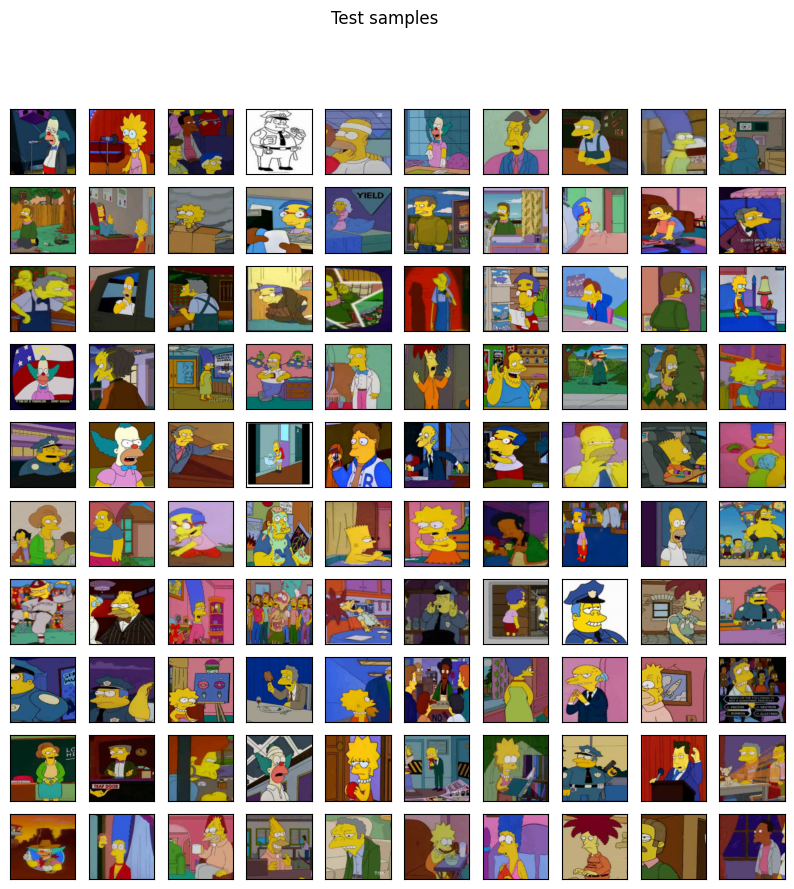

In [41]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0]*torch.tensor(norm_params[1]).reshape(3, 1, 1) + torch.tensor(norm_params[0]).reshape(3, 1, 1)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((255 * img).astype('uint8'))

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [42]:
print("Размерность данных в трейн сете: ", train_dataset[0][0].shape)
print("Размерность данных в тест сете: ", train_dataset[0][0].shape)

Размерность данных в трейн сете:  torch.Size([3, 128, 128])
Размерность данных в тест сете:  torch.Size([3, 128, 128])


Ит из нот веднесдей, май дудес, а если ресайз на 32, то тут был какой-то треш
charles_montgomery_burns


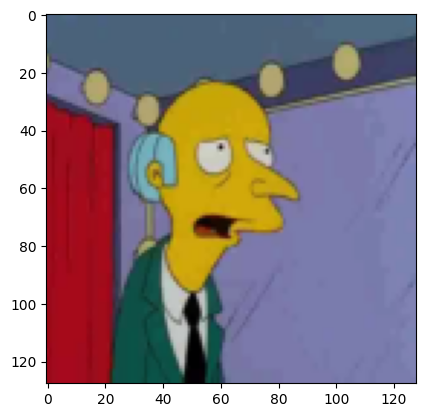

In [43]:
img = train_dataset[0][0]*torch.tensor(norm_params[1]).reshape(3, 1, 1) + torch.tensor(norm_params[0]).reshape(3, 1, 1)
img = img.numpy().transpose(1, 2, 0)
print("Ит из нот веднесдей, май дудес, а если ресайз на 32, то тут был какой-то треш")
train_dataset.get_label_encoder()
encdr = train_dataset.get_label_encoder()
encoded = encdr.inverse_transform([train_dataset[0][1]]).item()
print(encoded)
plot.imshow((255 * img).astype('uint8'))
plot.show()

2. Построение архитектуры

In [44]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(input_channels, output_channels, pool=False):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(output_channels),
              nn.ReLU(inplace=True)]
    if pool:
      layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class Net(nn.Module):
    def __init__(self, input_channels, number_of_classes):
        super().__init__()
        self.block1 = conv_block(input_channels, 64)
        self.block2 = nn.Sequential(conv_block(64, 64),
            conv_block(64, 128, True),
            conv_block(128, 128),
            conv_block(128, 256, True),
            conv_block(256, 256),
            conv_block(256, 512, True),
            conv_block(512, 512)
        )

        self.decoder = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512 * 4 * 4, number_of_classes))


    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.decoder(out)
        return out

In [45]:
num_classes = 42
net = Net(3, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
len(labels)

cuda:0


41866

In [46]:
from torchsummary import summary
from torchviz import make_dot

summary(net, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

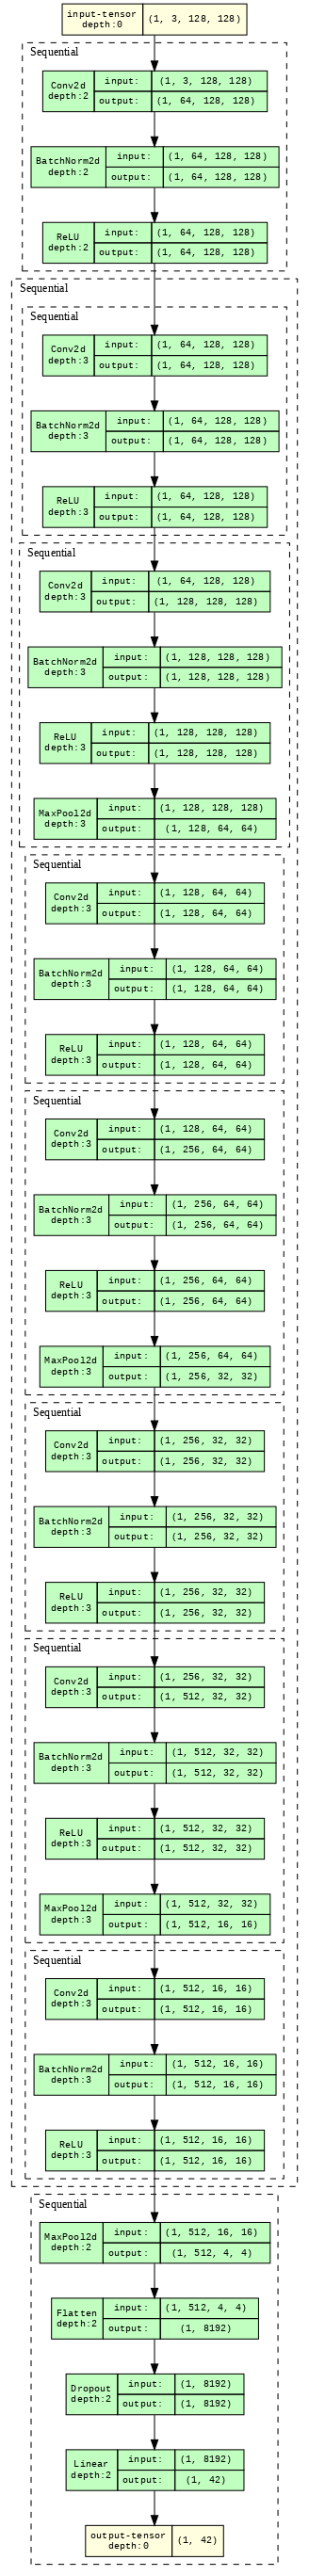

In [47]:
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format('png')
model_graph = draw_graph(net, input_size=(1,3,128,128), expand_nested=True)
model_graph.visual_graph

In [48]:
import torch.optim as optim
import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [49]:
def get_f1(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    val = tp / n
    return 2 * val * val / (val + val)

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy_f1(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [50]:
epochs = 30
start_time = time.time()
for epoch in range(epochs):
  start_epoch = time.time()
  accuracies = []
  losses = []
  for i, (images, labels) in enumerate(train_data_loader):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = net(images)
      loss = criterion(outputs, labels)
      acc = accuracy_f1(outputs, labels)

      losses.append(loss)
      accuracies.append(acc)

      loss.backward()
      optimizer.step()
  total_time_epoch = time.time() - start_epoch
  print('Epoch[{}]: Loss = {:.4f}, f1 scope = {:.4f}, epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
total_time = time.time() - start_time
print('time {}'.format(total_time))

Epoch[1]: Loss = 2.4537, f1 scope = 0.4189, epoch = 233.9075
Epoch[2]: Loss = 0.8887, f1 scope = 0.7560, epoch = 217.6961
Epoch[3]: Loss = 0.5364, f1 scope = 0.8506, epoch = 217.9658
Epoch[4]: Loss = 0.3659, f1 scope = 0.8958, epoch = 218.0438
Epoch[5]: Loss = 0.2730, f1 scope = 0.9219, epoch = 218.1763
Epoch[6]: Loss = 0.1973, f1 scope = 0.9431, epoch = 218.0266
Epoch[7]: Loss = 0.1517, f1 scope = 0.9543, epoch = 217.5133
Epoch[8]: Loss = 0.1194, f1 scope = 0.9652, epoch = 218.6487
Epoch[9]: Loss = 0.0909, f1 scope = 0.9724, epoch = 218.2860
Epoch[10]: Loss = 0.0833, f1 scope = 0.9738, epoch = 218.6739
Epoch[11]: Loss = 0.0668, f1 scope = 0.9800, epoch = 219.4856
Epoch[12]: Loss = 0.0596, f1 scope = 0.9828, epoch = 218.8975
Epoch[13]: Loss = 0.0589, f1 scope = 0.9828, epoch = 218.2310
Epoch[14]: Loss = 0.0397, f1 scope = 0.9880, epoch = 218.0644
Epoch[15]: Loss = 0.0499, f1 scope = 0.9850, epoch = 218.4444
Epoch[16]: Loss = 0.0418, f1 scope = 0.9876, epoch = 219.0837
Epoch[17]: Loss =

In [51]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(net, test_data_loader, device),
    get_f1(net, test_data_loader, device)))

Loss = 0.0039, Test accuracy = 0.9592
